### Notebook 3 of Capstone Project: Modelling Using SARIMA!

import the needed libraries here:

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import EnsembleForecaster

import pmdarima as pmd
from pmdarima.utils import tsdisplay

In [210]:
data = pd.read_csv('oil_and_gas_data/data_for_modelling/data_ready_for_modelling.csv', index_col=0)
data.head()

,Daily_Avg,Daily_Sum,Daily_Count,Dly_Cnt_Diff,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2016-01-01,0.0,0.0,0,NaN,33.0,37.13,36.61,9.0,5.080098e+06,1088.829502
2016-01-02,0.0,0.0,0,0.0,33.0,37.13,36.61,11.0,5.892634e+06,1044.749861
2016-01-03,0.0,0.0,0,0.0,33.0,37.13,36.61,9.0,4.539134e+06,1125.551135
2016-01-04,0.0,0.0,0,0.0,33.0,36.81,36.28,26.0,1.135010e+07,848.112281
2016-01-05,0.0,0.0,0,0.0,33.0,35.97,35.56,26.0,1.135010e+07,848.112281


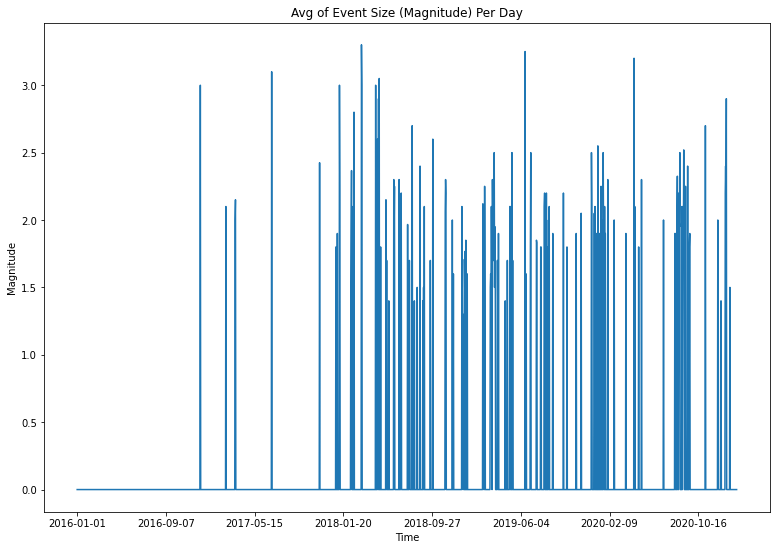

In [211]:
data['Daily_Avg'].plot(figsize=(13,9))
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Avg of Event Size (Magnitude) Per Day');

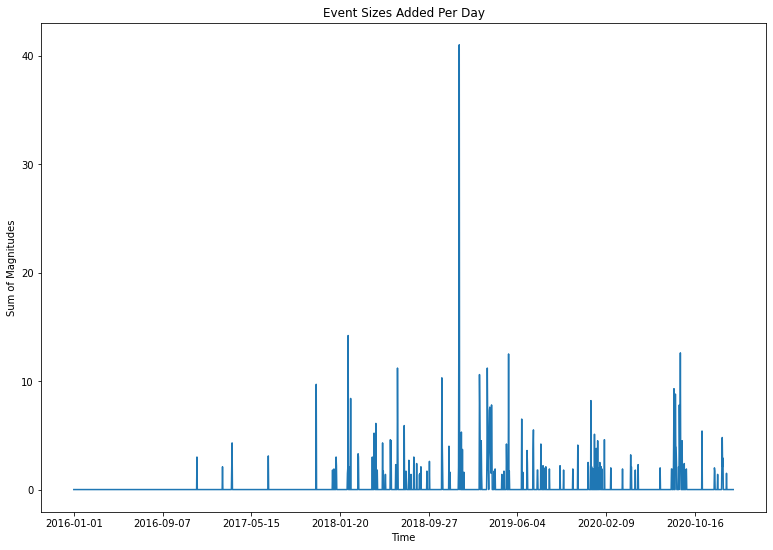

In [212]:
data['Daily_Sum'].plot(figsize=(13,9))
plt.xlabel('Time')
plt.ylabel('Sum of Magnitudes')
plt.title('Event Sizes Added Per Day');

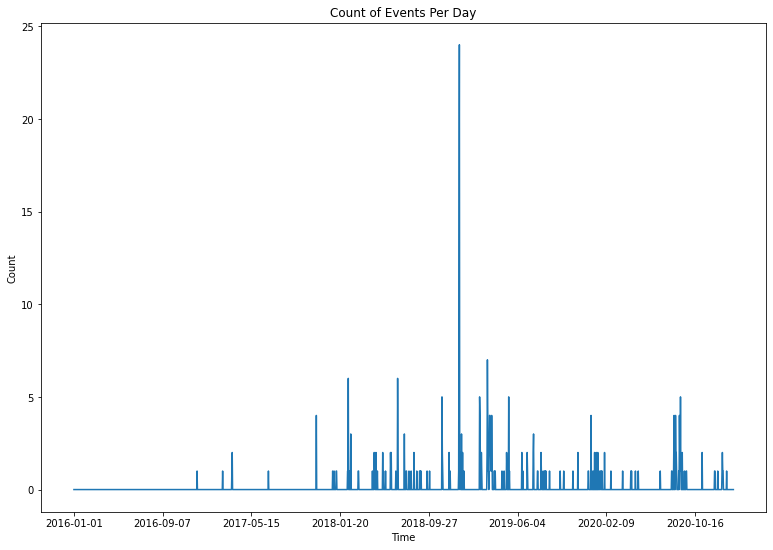

In [213]:
data['Daily_Count'].plot(figsize=(13,9))
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Count of Events Per Day');

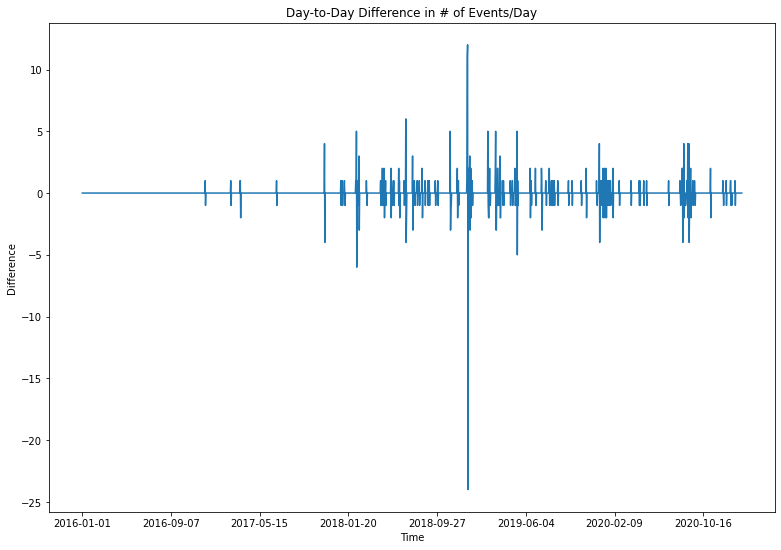

In [214]:
data['Dly_Cnt_Diff'].plot(figsize=(13,9))
plt.xlabel('Time')
plt.ylabel('Difference')
plt.title('Day-to-Day Difference in # of Events/Day');

I am going to use data from 1/1/2017 to 9/30/2019 to forecast seismicity that occurred in 3Q 2019 - 1Q 2020. In trying to model the daily data, I've learned that the models run REALLY REALLY slow, even on google co-lab, so I have to resample this dataframe to weekly. So I'll do that first and take a look at similar plots as above.

In [215]:
data.index = pd.to_datetime(data.index)

In [216]:
weekly_data = data.resample('W').mean()
weekly_data.head(3)

,Daily_Avg,Daily_Sum,Daily_Count,Dly_Cnt_Diff,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2016-01-03,0.0,0.0,0.0,0.0,33.0,37.130000,36.610000,9.666667,5.170622e+06,1086.376832
2016-01-10,0.0,0.0,0.0,0.0,33.0,34.234286,33.472857,26.571429,1.235401e+07,825.894278
2016-01-17,0.0,0.0,0.0,0.0,33.0,30.261429,29.014286,24.285714,1.620145e+07,1014.034459


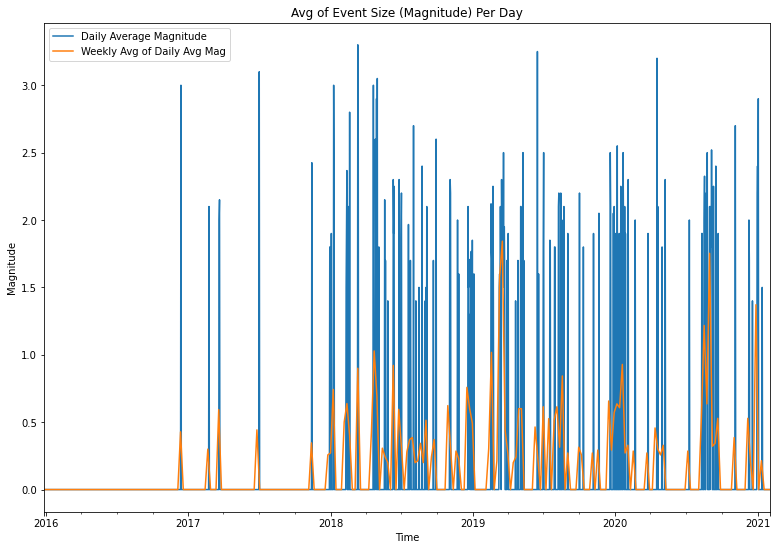

In [217]:
data['Daily_Avg'].plot(figsize=(13,9), label='Daily Average Magnitude')
weekly_data['Daily_Avg'].plot(figsize=(13,9), label='Weekly Avg of Daily Avg Mag')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Avg of Event Size (Magnitude) Per Day')
plt.legend();

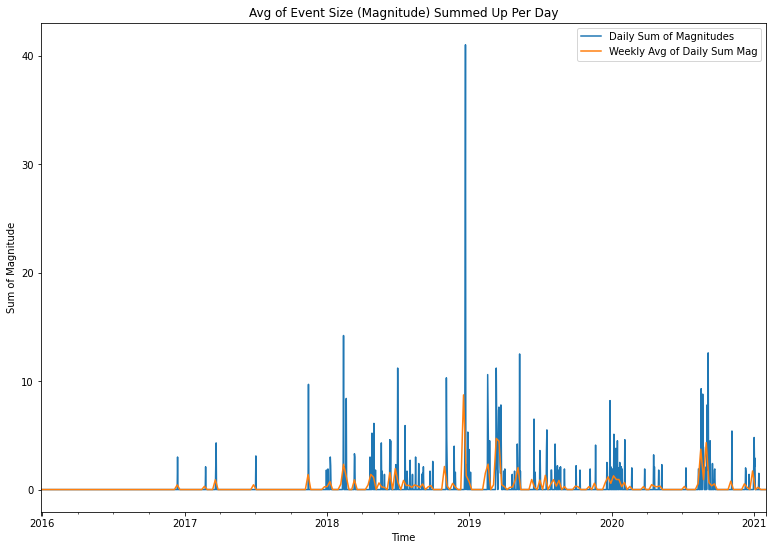

In [218]:
data['Daily_Sum'].plot(figsize=(13,9), label='Daily Sum of Magnitudes')
weekly_data['Daily_Sum'].plot(figsize=(13,9), label='Weekly Avg of Daily Sum Mag')
plt.xlabel('Time')
plt.ylabel('Sum of Magnitude')
plt.title('Avg of Event Size (Magnitude) Summed Up Per Day')
plt.legend();

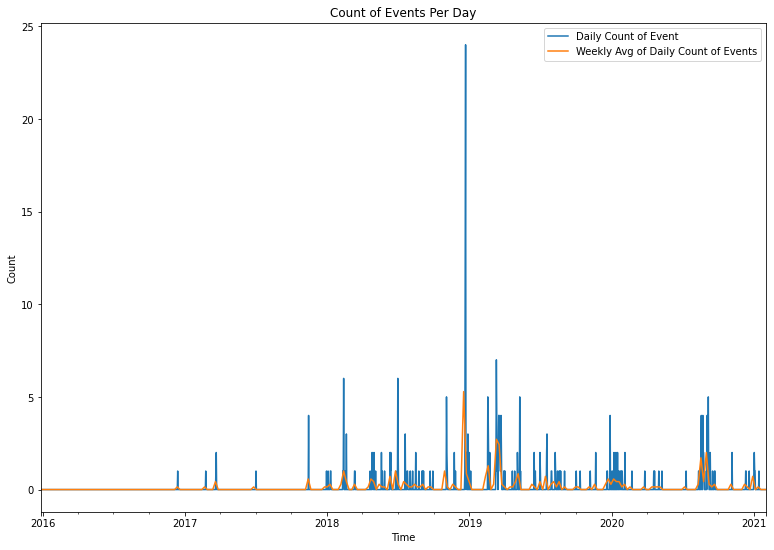

In [219]:
data['Daily_Count'].plot(figsize=(13,9), label='Daily Count of Event')
weekly_data['Daily_Count'].plot(figsize=(13,9), label='Weekly Avg of Daily Count of Events')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Count of Events Per Day')
plt.legend();

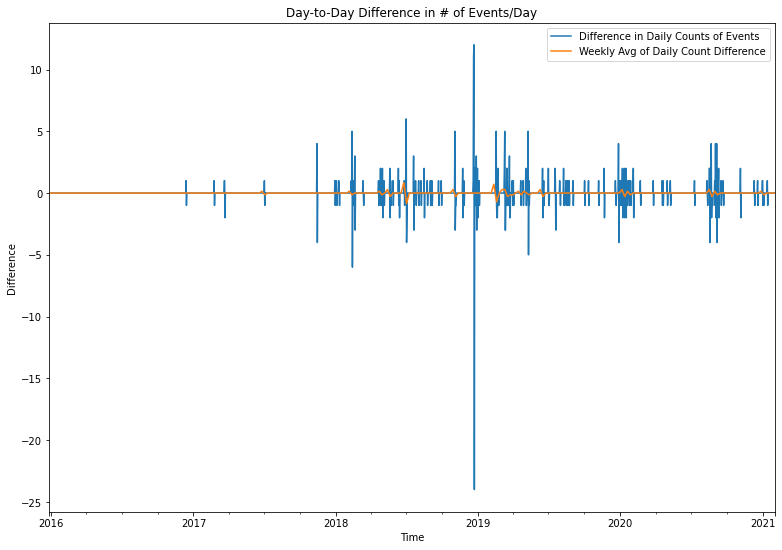

In [220]:
data['Dly_Cnt_Diff'].plot(figsize=(13,9), label='Difference in Daily Counts of Events')
weekly_data['Dly_Cnt_Diff'].plot(figsize=(13,9), label='Weekly Avg of Daily Count Difference')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.title('Day-to-Day Difference in # of Events/Day')
plt.legend();

Next steps are to split into train and test sets, then set up a baseline model.

In [221]:
train_subset =  weekly_data.loc['2017':'9-30-2019',]
test_subset = weekly_data.loc['10-1-2019':'3-31-2020',]

In [222]:
train_subset.tail()

,Daily_Avg,Daily_Sum,Daily_Count,Dly_Cnt_Diff,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2019-09-01,0.000000,0.000000,0.000000,0.0,29.285714,55.167143,60.172857,15.285714,1.328686e+07,2281.137619
2019-09-08,0.271429,0.271429,0.142857,0.0,30.000000,55.840000,60.528571,16.285714,1.216854e+07,2229.285065
2019-09-15,0.000000,0.000000,0.000000,0.0,30.000000,55.760000,62.312857,15.000000,7.904135e+06,1946.664092
2019-09-22,0.000000,0.000000,0.000000,0.0,29.428571,58.928571,65.462857,24.285714,2.016906e+07,2928.348256
2019-09-29,0.000000,0.000000,0.000000,0.0,27.142857,56.625714,62.960000,33.000000,3.260728e+07,3404.418694


In [223]:
test_subset.tail()

,Daily_Avg,Daily_Sum,Daily_Count,Dly_Cnt_Diff,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2020-03-01,0.000000,0.000000,0.000000,0.0,33.000000,47.352857,53.297143,17.142857,1.725344e+07,2671.754794
2020-03-08,0.000000,0.000000,0.000000,0.0,32.714286,44.307143,49.244286,28.000000,2.196417e+07,2541.374936
2020-03-15,0.000000,0.000000,0.000000,0.0,32.000000,32.195714,33.302857,30.571429,2.360722e+07,2545.060663
2020-03-22,0.000000,0.000000,0.000000,0.0,32.285714,22.847143,25.624286,32.000000,2.262417e+07,2586.057358
2020-03-29,0.271429,0.271429,0.142857,0.0,32.142857,18.307143,23.512857,33.000000,1.900354e+07,2374.692438


In [224]:
y_train = train_subset[['Daily_Count']]
y_test = test_subset[['Daily_Count']]

In [225]:
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

In [226]:
y_train.tail()

,Daily_Count
2019-09-01,0.000000
2019-09-08,0.142857
2019-09-15,0.000000
2019-09-22,0.000000
2019-09-29,0.000000


My first baseline model will be a Naive Forecast model, which uses the last value of the train set to predict the future values (test set). What am I trying to predict? I'll start by predicting Daily Count of events.

In [227]:
df_predictions = y_test.copy()
df_predictions['last'] = y_train['Daily_Count'].iloc[-1]
df_predictions.head(5)

,Daily_Count,last
2019-10-06,0.142857,0.0
2019-10-13,0.142857,0.0
2019-10-20,0.000000,0.0
2019-10-27,0.000000,0.0
2019-11-03,0.000000,0.0


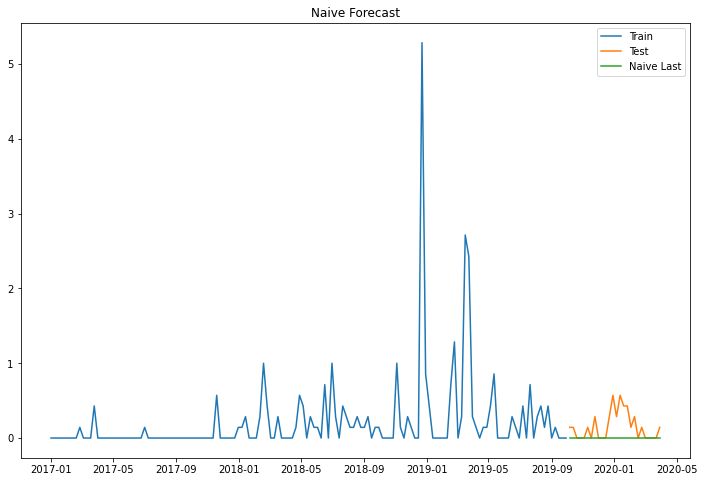

In [228]:
#let's get a visual of this naive forecast
plt.figure(figsize=(12,8))

plt.plot(y_train.index, y_train['Daily_Count'], label='Train')
plt.plot(y_test.index, y_test['Daily_Count'], label='Test')
plt.plot(df_predictions.index, df_predictions['last'], label="Naive Last")

plt.legend(loc='best')
plt.title("Naive Forecast");

So the naive forecast has just predicted zero, which makes sense because we told it to use the last value of the train set, which is zero. I'd like to use mean squared error to score the model.

In [229]:
np.round(mse(df_predictions['Daily_Count'], df_predictions['last'], squared=False), decimals=2)

0.24

The interpretation of these metrics is that the naive (last) model has an rmse error of +/- 0.24 on the daily count of events (range in test set was 0 - 0.5 events per day).

Let's try another baseline where we use a simple average of the Daily Count of events in the training set to predict the Daily Count of events in the test set.

In [230]:
df_predictions['simple_mean'] = y_train['Daily_Count'].mean()
df_predictions.head(3)

,Daily_Count,last,simple_mean
2019-10-06,0.142857,0.0,0.210317
2019-10-13,0.142857,0.0,0.210317
2019-10-20,0.000000,0.0,0.210317


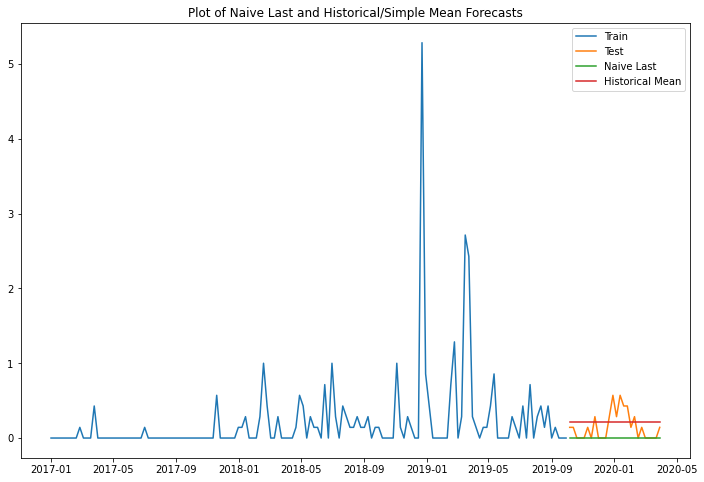

In [231]:
#let's get a visual of this naive forecast
plt.figure(figsize=(12,8))

plt.plot(y_train.index, y_train['Daily_Count'], label='Train')
plt.plot(y_test.index, y_test['Daily_Count'], label='Test')
plt.plot(df_predictions.index, df_predictions['last'], label="Naive Last")
plt.plot(df_predictions.index, df_predictions['simple_mean'], label='Historical Mean')

plt.legend(loc='best')
plt.title("Plot of Naive Last and Historical/Simple Mean Forecasts");

In [232]:
#again, I'll calculate the rmse for the simple mean case
np.round(mse(df_predictions['Daily_Count'], df_predictions['simple_mean'], squared=False), decimals=2)

0.19

This model did a little bit better than the last, a lower rmse error of 0.19.

In [233]:
#Going to to the same baseline models using sktime
#start with the naive (last) model
#sktime likes the format of things just so
y_train.index = y_train.index.to_period('W')
y_test.index = y_test.index.to_period('W')

In [234]:
y_train = y_train['Daily_Count']
y_test = y_test['Daily_Count']

In [235]:
#here is the last value/naive model
naive_last = NaiveForecaster(strategy= 'last')
naive_last.fit(y_train)

NaiveForecaster()

In [236]:
y_last_preds = naive_last.predict(list(range(1,len(y_test)+1)))

In [237]:
#get the rmse for the last/naive model
np.round(mse(y_test, y_last_preds, squared=False), decimals=2)

0.24

In [238]:
#here is the simple mean model
naive_mean = NaiveForecaster(strategy= 'mean')
naive_mean.fit(y_train)

NaiveForecaster(strategy='mean')

In [239]:
y_mean_preds = naive_mean.predict(list(range(1,len(y_test)+1)))

In [240]:
#get the rmse for the mean model
np.round(mse(y_test, y_mean_preds, squared=False), decimals=2)

0.19

In [241]:
y_test

2019-09-30/2019-10-06    0.142857
2019-10-07/2019-10-13    0.142857
2019-10-14/2019-10-20    0.000000
2019-10-21/2019-10-27    0.000000
2019-10-28/2019-11-03    0.000000
2019-11-04/2019-11-10    0.142857
2019-11-11/2019-11-17    0.000000
2019-11-18/2019-11-24    0.285714
2019-11-25/2019-12-01    0.000000
2019-12-02/2019-12-08    0.000000
2019-12-09/2019-12-15    0.000000
2019-12-16/2019-12-22    0.285714
2019-12-23/2019-12-29    0.571429
2019-12-30/2020-01-05    0.285714
2020-01-06/2020-01-12    0.571429
2020-01-13/2020-01-19    0.428571
2020-01-20/2020-01-26    0.428571
2020-01-27/2020-02-02    0.142857
2020-02-03/2020-02-09    0.285714
2020-02-10/2020-02-16    0.000000
2020-02-17/2020-02-23    0.142857
2020-02-24/2020-03-01    0.000000
2020-03-02/2020-03-08    0.000000
2020-03-09/2020-03-15    0.000000
2020-03-16/2020-03-22    0.000000
2020-03-23/2020-03-29    0.142857
Freq: W-SUN, Name: Daily_Count, dtype: float64

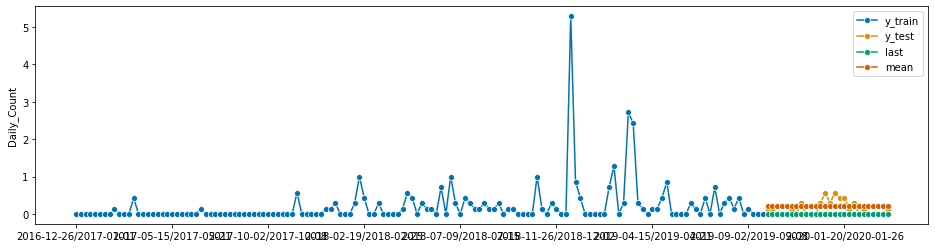

In [242]:
plot_series(y_train, y_test, y_last_preds, y_mean_preds,
            labels=['y_train', 'y_test', 'last', 'mean']);

Let's move on to a Holt-Winters model and see how that does.

In [243]:
#df.astype('float64')
y_train = y_train.astype('float64')

In [244]:
hw_model = AutoETS(error='add', trend='add', seasonal='add', suppress_warnings=True, sp=52)

In [245]:
hw_model.fit(y_train)

AutoETS(seasonal='add', sp=52, trend='add')

In [246]:
hw_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:            Daily_Count   No. Observations:                  144
Model:                       ETS(AAA)   Log Likelihood                 -75.224
Date:                Wed, 03 Mar 2021   AIC                            266.448
Time:                        10:00:00   BIC                            438.697
Sample:                    01-01-2017   HQIC                           336.440
                         - 09-29-2019   Scale                            0.166
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.0001        nan        nan        nan         nan         nan
smoothing_trend          1e-08      0.001   6.84e-06      1.000      -0.003       0.003
smoothing_seasonal   9.999e-05        nan        nan        nan         nan         nan
initial_level           0.1432   1310.925      0.000      1.000   -2569.222    2569.509
initial_trend           0.0036      0.001      2.653      0.008       0.001       0.006
initial_seasonal.0      2.2194   1310.925      0.002      0.999   -2567.146    2571.585
initial_seasonal.1     -0.4212   1310.925     -0.000      1.000   -2569.786    2568.944
initial_seasonal.2     -0.4176   1310.925     -0.000      1.000   -2569.783    2568.948
initial_seasonal.3     -0.3426   1310.925     -0.000      1.000   -2569.708    2569.023
initial_seasonal.4     -0.2675   1310.925     -0.000      1.000   -2569.633    2569.098
initial_seasonal.5     -0.1213   1310.925  -9.25e-05      1.000   -2569.486    2569.244
initial_seasonal.6     -0.3318   1310.925     -0.000      1.000   -2569.697    2569.033
initial_seasonal.7      0.1005   1310.925   7.67e-05      1.000   -2569.264    2569.466
initial_seasonal.8     -0.3961   1310.925     -0.000      1.000   -2569.761    2568.969
initial_seasonal.9     -0.3926   1310.925     -0.000      1.000   -2569.758    2568.972
initial_seasonal.10    -0.3890   1310.925     -0.000      1.000   -2569.754    2568.976
initial_seasonal.11    -0.3854   1310.925     -0.000      1.000   -2569.750    2568.980
initial_seasonal.12    -0.4282   1310.925     -0.000      1.000   -2569.795    2568.939
initial_seasonal.13    -0.4245   1310.925     -0.000      1.000   -2569.791    2568.942
initial_seasonal.14    -0.4684   1310.925     -0.000      1.000   -2569.835    2568.898
initial_seasonal.15    -0.3217   1310.925     -0.000      1.000   -2569.688    2569.045
initial_seasonal.16    -0.4133   1310.925     -0.000      1.000   -2569.780    2568.953
initial_seasonal.17    -0.2667   1310.925     -0.000      1.000   -2569.633    2569.100
initial_seasonal.18    -0.3107   1310.925     -0.000      1.000   -2569.677    2569.056
initial_seasonal.19    -0.2594   1310.925     -0.000      1.000   -2569.626    2569.107
initial_seasonal.20    -0.3034   1310.925     -0.000      1.000   -2569.670    2569.063
initial_seasonal.21    -0.3474   1310.925     -0.000      1.000   -2569.714    2569.019
initial_seasonal.22    -0.0579   1310.925  -4.42e-05      1.000   -2569.424    2569.308
initial_seasonal.23    -0.4354   1310.925     -0.000      1.000   -2569.802    2568.931
initial_seasonal.24    -0.1936   1310.925     -0.000      1.000   -2569.560    2569.173
initial_seasonal.25    -0.0471   1310.925  -3.59e-05      1.000   -2569.413    2569.319
initial_seasonal.26    -0.3768   1310.925     -0.000      1.000   -2569.743    2568.989
initial_seasonal.27    -0.0874   1310.925  -6.67e-05      1.000   -2569.454    2569.279
initial_seasonal.28    -0.4172   1310.925     -0.000      1.000   -2569.7

In [247]:
manual_preds = hw_model.predict(list(range(1,len(y_test)+1)))

In [248]:
round(mse(y_test, manual_preds, squared=False),0)

1.0

/Users/melissamcmillan/opt/anaconda3/envs/timer/lib/python3.8/site-packages/pmdarima/utils/visualization.py:219: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  res = tsaplots.plot_acf(


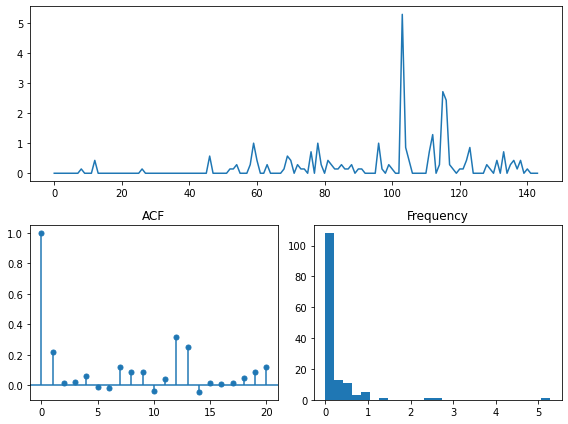

In [38]:
#I'm going to try an auto-arima model
tsdisplay(y_train, lag_max=20)

In [39]:
model = pmd.auto_arima(y_train, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.24 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=311.774, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=294.935, Time=0.40 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=309.774, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=293.042, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=294.944, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=3.06 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=280.384, Time=0.03 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=282.338, Time=0.75 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=282.341, Time=0.53 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=3.75 sec
 ARIMA(3,1,0)(0,0,0)[52] intercept   : AIC=272.607, Time=0.04 sec
 ARIMA(3,1,0)(1,0,0)[52] intercept   : AIC=274.563, Time=0.85 sec
 ARIMA(3,1,0)(0,0,1)[52] intercept   : AIC=274.56

In [40]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -119.137
Date:                Mon, 01 Mar 2021   AIC                            244.273
Time:                        18:57:21   BIC                            253.162
Sample:                             0   HQIC                           247.885
                                - 144                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7675      0.072    -10.592      0.000      -0.909      -0.625
ma.L2         -0.1819      0.094     -1.936      0.053      -0.366       0.002
sigma2         0.3052      0.008     39.616      0.000       0.290       0.320
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             16706.35
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):              70.34   Skew:                             6.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        54.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
arima_preds = model.predict(y_test.shape[0])
arima_preds = pd.Series(arima_preds, y_test.index)
arima_preds

2019-09-30/2019-10-06    0.240798
2019-10-07/2019-10-13    0.286788
2019-10-14/2019-10-20    0.286788
2019-10-21/2019-10-27    0.286788
2019-10-28/2019-11-03    0.286788
2019-11-04/2019-11-10    0.286788
2019-11-11/2019-11-17    0.286788
2019-11-18/2019-11-24    0.286788
2019-11-25/2019-12-01    0.286788
2019-12-02/2019-12-08    0.286788
2019-12-09/2019-12-15    0.286788
2019-12-16/2019-12-22    0.286788
2019-12-23/2019-12-29    0.286788
2019-12-30/2020-01-05    0.286788
2020-01-06/2020-01-12    0.286788
2020-01-13/2020-01-19    0.286788
2020-01-20/2020-01-26    0.286788
2020-01-27/2020-02-02    0.286788
2020-02-03/2020-02-09    0.286788
2020-02-10/2020-02-16    0.286788
2020-02-17/2020-02-23    0.286788
2020-02-24/2020-03-01    0.286788
2020-03-02/2020-03-08    0.286788
2020-03-09/2020-03-15    0.286788
2020-03-16/2020-03-22    0.286788
2020-03-23/2020-03-29    0.286788
Freq: W-SUN, dtype: float64

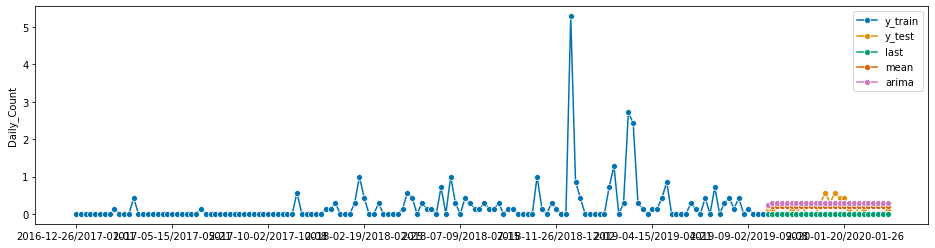

In [42]:
plot_series(y_train, y_test, y_last_preds, y_mean_preds, arima_preds,
            labels=['y_train', 'y_test', 'last', 'mean', 'arima']);

In [43]:
#get the rmse for the sarimax model
np.round(mse(y_test, arima_preds, squared=False), decimals=2)

0.22

In [ ]:
#that one did worse than the mean model in terms of rmse

Now I'm going to try a sarimax model that takes in exogenous features. The first exogenous feature I want to try is Rig Count. It's a pretty straight-forward feature to understand.

In [45]:
sarimax_rigs = pmd.auto_arima(y_train, X=train_subset[['Rig_Count']], m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.49 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=313.092, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=296.472, Time=0.67 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=3.05 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=311.092, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=294.541, Time=0.04 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=296.477, Time=0.76 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=3.25 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=280.802, Time=0.04 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=282.796, Time=1.13 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=282.796, Time=0.70 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=4.35 sec
 ARIMA(3,1,0)(0,0,0)[52] intercept   : AIC=273.176, Time=0.07 sec
 ARIMA(3,1,0)(1,0,0)[52] intercept   : AIC=275.173, Time=1.22 sec
 ARIMA(3,1,0)(0,0,1)[52] intercept   : AIC=275.17

In [46]:
sarimax_rigs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -118.910
Date:                Mon, 01 Mar 2021   AIC                            245.819
Time:                        18:59:33   BIC                            257.671
Sample:                    01-01-2017   HQIC                           250.635
                         - 09-29-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Rig_Count      0.0140      0.053      0.262      0.793      -0.090       0.118
ma.L1         -0.7667      0.073    -10.451      0.000      -0.910      -0.623
ma.L2         -0.1818      0.096     -1.900      0.057      -0.369       0.006
sigma2         0.3042      0.008     37.140      0.000       0.288       0.320
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             16700.00
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):              62.32   Skew:                             6.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        54.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
test_subset[['Rig_Count']].shape

(26, 1)

In [48]:
y_test.shape

(26,)

In [49]:
sarimax_rigs_preds = sarimax_rigs.predict(y_test.shape[0], test_subset[['Rig_Count']])
sarimax_rigs_preds

array([0.17074033, 0.20800861, 0.20401813, 0.19404194, 0.19404194,
       0.19404194, 0.20202289, 0.22197529, 0.22197529, 0.22197529,
       0.23394672, 0.26786579, 0.27784199, 0.27784199, 0.28582294,
       0.30976581, 0.31974201, 0.31974201, 0.31974201, 0.31575153,
       0.30976581, 0.31974201, 0.31575153, 0.30577534, 0.30976581,
       0.30777058])

In [50]:
#get the rmse for the sarimax model
np.round(mse(y_test, sarimax_rigs_preds, squared=False), decimals=2)

0.21

The rmse went down a tiny bit but the AIC score went up a bit. I'm going to try using the WTI Spot price next.

In [51]:
X = train_subset[['WTI_Spot_Price']]

In [52]:
sarimax_wti = pmd.auto_arima(y_train, X=X, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.80 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=311.630, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=294.290, Time=0.70 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=249.720, Time=2.18 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=309.631, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=247.741, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=249.718, Time=1.82 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=251.719, Time=1.67 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=292.379, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[52]             : AIC=246.166, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[52]             : AIC=248.152, Time=0.83 sec
 ARIMA(0,1,1)(0,0,1)[52]             : AIC=248.15

In [53]:
sarimax_wti.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -118.365
Date:                Mon, 01 Mar 2021   AIC                            244.730
Time:                        19:00:19   BIC                            256.581
Sample:                    01-01-2017   HQIC                           249.546
                         - 09-29-2019                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
WTI_Spot_Price    -0.0125      0.012     -1.089      0.276      -0.035       0.010
ma.L1             -0.7682      0.060    -12.860      0.000      -0.885      -0.651
ma.L2             -0.1624      0.090     -1.810      0.070      -0.338       0.013
sigma2             0.3025      0.022     13.901      0.000       0.260       0.345
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             12820.18
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):              60.31   Skew:                             5.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        47.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
sarimax_wti_preds = sarimax_wti.predict(y_test.shape[0], test_subset[['WTI_Spot_Price']])
np.round(mse(y_test, sarimax_wti_preds, squared=False), decimals=2)

0.31

Well that didn't improve much, the rmse got worse. Now I'll try to test Rig Count with WTI price and see how that does.

In [55]:
X = train_subset[['Rig_Count', 'WTI_Spot_Price']]

In [56]:
sarimax_rigs_wti = pmd.auto_arima(y_train, X=X, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.91 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=313.102, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=295.958, Time=0.70 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=251.506, Time=1.79 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=311.102, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=249.548, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=251.502, Time=1.77 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=4.36 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=294.015, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[52]             : AIC=247.892, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[52]             : AIC=249.853, Time=1.20 sec
 ARIMA(0,1,1)(0,0,1)[52]             : AIC=249.856, T

In [57]:
sarimax_rigs_wti.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -118.243
Date:                Mon, 01 Mar 2021   AIC                            246.486
Time:                        19:01:11   BIC                            261.300
Sample:                    01-01-2017   HQIC                           252.505
                         - 09-29-2019                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Rig_Count          0.0105      0.048      0.218      0.827      -0.083       0.104
WTI_Spot_Price    -0.0120      0.012     -0.973      0.331      -0.036       0.012
ma.L1             -0.7673      0.064    -11.990      0.000      -0.893      -0.642
ma.L2             -0.1624      0.090     -1.804      0.071      -0.339       0.014
sigma2             0.3020      0.025     11.892      0.000       0.252       0.352
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             12948.99
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):              54.29   Skew:                             5.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
sarimax_rigs_wti_preds = sarimax_rigs_wti.predict(y_test.shape[0], test_subset[['Rig_Count','WTI_Spot_Price']])
np.round(mse(y_test, sarimax_rigs_wti_preds, squared=False), decimals=2)

0.3

Meh, I didn't think that would help anyway. Okay, now I'd like to move on to testing fracs/day.

In [59]:
X = train_subset[['fracs_per_day']]

In [60]:
sarimax_fracs = pmd.auto_arima(y_train, X=X, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.44 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=310.706, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=294.224, Time=1.34 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=308.707, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=292.255, Time=0.07 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=294.227, Time=0.91 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=3.02 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=279.428, Time=0.06 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=281.420, Time=1.33 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=281.421, Time=1.32 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=283.420, Time=1.72 sec
 ARIMA(3,1,0)(0,0,0)[52] intercept   : AIC=272.131, Time=0.14 sec
 ARIMA(3,1,0)(1,0,0)[52] intercept   : AIC=274.109, Time=1.95 sec
 ARIMA(3,1,0)(0,0,1)[52] intercept   : AIC=27

In [61]:
sarimax_fracs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -118.955
Date:                Mon, 01 Mar 2021   AIC                            245.910
Time:                        19:02:41   BIC                            257.762
Sample:                    01-01-2017   HQIC                           250.726
                         - 09-29-2019                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
fracs_per_day     0.0029      0.015      0.202      0.840      -0.026       0.031
ma.L1            -0.7634      0.074    -10.353      0.000      -0.908      -0.619
ma.L2            -0.1848      0.101     -1.825      0.068      -0.383       0.014
sigma2            0.3044      0.008     39.398      0.000       0.289       0.320
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             16848.08
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):              62.91   Skew:                             6.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        54.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
sarimax_fracs_preds = sarimax_fracs.predict(y_test.shape[0], test_subset[['fracs_per_day']])
np.round(mse(y_test, sarimax_fracs_preds, squared=False), decimals=2)

0.23

Meh, still sort of mediocre results. Going to try volume/day next.

In [63]:
X = train_subset[['volume_per_day']]
sarimax_volume = pmd.auto_arima(y_train, X=X, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=267.585, Time=4.31 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=305.694, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=290.960, Time=2.64 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=270.752, Time=2.41 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=871.389, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=265.585, Time=3.08 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=263.585, Time=0.22 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=265.300, Time=4.00 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=262.668, Time=0.20 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=264.641, Time=3.26 sec
 ARIMA(1,1,2)(0,0,1)[52] intercept   : AIC=264.668, Time=3.00 sec
 ARIMA(1,1,2)(1,0,1)[52] intercept   : AIC=266.668, Time=3.82 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=258.045, Time=0.20 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=260.043, Time=2.95 sec
 ARIMA(0,1,2)(0,0,1)[52] intercep

In [64]:
sarimax_volume.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -122.451
Date:                Mon, 01 Mar 2021   AIC                            254.901
Time:                        19:03:45   BIC                            269.715
Sample:                    01-01-2017   HQIC                           260.921
                         - 09-29-2019                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
volume_per_day  9.188e-09   1.94e-08      0.474      0.635   -2.88e-08    4.72e-08
ma.L1             -0.5948      0.057    -10.449      0.000      -0.706      -0.483
ma.L2             -0.2008      0.127     -1.579      0.114      -0.450       0.048
ma.L3             -0.0241      0.094     -0.256      0.798      -0.209       0.161
sigma2             0.3747      0.019     19.792      0.000       0.338       0.412
===================================================================================
Ljung-Box (L1) (Q):                   2.07   Jarque-Bera (JB):             14041.88
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):              52.87   Skew:                             5.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        50.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
sarimax_vol_preds = sarimax_volume.predict(y_test.shape[0], test_subset[['volume_per_day']])
np.round(mse(y_test, sarimax_vol_preds, squared=False), decimals=2)

0.23

The rmse for that model did as well as the fracs/day, but the AIC score was worse. Going to use my last feature, and then I'll try to test with a different target.

In [66]:
X = train_subset[['avg_volh2o_per_ft']]
sarimax_vol_ft = pmd.auto_arima(y_train, X=X, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=269.128, Time=4.69 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=313.765, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=297.083, Time=1.15 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=272.930, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=311.766, Time=0.12 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=267.014, Time=3.76 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=265.180, Time=0.26 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=267.938, Time=4.40 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=261.249, Time=0.14 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=263.724, Time=1.34 sec
 ARIMA(1,1,2)(0,0,1)[52] intercept   : AIC=263.249, Time=1.29 sec
 ARIMA(1,1,2)(1,0,1)[52] intercept   : AIC=265.249, Time=1.40 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=254.930, Time=0.08 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=257.287, Time=2.20 sec
 ARIMA(0,1,2)(0,0,1)[52] intercep

In [67]:
sarimax_vol_ft.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -120.399
Date:                Mon, 01 Mar 2021   AIC                            250.798
Time:                        19:04:26   BIC                            265.612
Sample:                    01-01-2017   HQIC                           256.818
                         - 09-29-2019                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
avg_volh2o_per_ft -8.725e-05      0.000     -0.197      0.844      -0.001       0.001
ma.L1                -0.6969      0.068    -10.245      0.000      -0.830      -0.564
ma.L2                -0.2260      0.177     -1.274      0.203      -0.574       0.122
ma.L3                -0.0349      0.134     -0.259      0.795      -0.298       0.229
sigma2                0.3596      0.020     17.778      0.000       0.320       0.399
===================================================================================
Ljung-Box (L1) (Q):                   1.20   Jarque-Bera (JB):             16366.42
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):              68.70   Skew:                             6.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        53.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
sarimax_vol_ft_preds = sarimax_vol_ft.predict(y_test.shape[0], test_subset[['avg_volh2o_per_ft']])
np.round(mse(y_test, sarimax_vol_ft_preds, squared=False), decimals=2)

0.21

Okay, not much improvement. I'm going to switch to using Daily Sum as a target and see if that does any better.

In [69]:
#Going to to the same baseline models using sktime
#start with the naive (last) model
#sktime likes the format of things just so
y_train = train_subset['Daily_Sum']
y_test = test_subset['Daily_Sum']
y_train.index = y_train.index.to_period('W')
y_test.index = y_test.index.to_period('W')

In [70]:
#here is the last value/naive model
naive_last = NaiveForecaster(strategy= 'last')
naive_last.fit(y_train)

NaiveForecaster()

In [71]:
y_last_preds = naive_last.predict(list(range(1,len(y_test)+1)))
#get the rmse for the last/naive model
np.round(mse(y_test, y_last_preds, squared=False), decimals=2)

0.51

In [72]:
#here is the simple mean model
naive_mean = NaiveForecaster(strategy= 'mean')
naive_mean.fit(y_train)
y_mean_preds = naive_mean.predict(list(range(1,len(y_test)+1)))
#get the rmse for the mean model
np.round(mse(y_test, y_mean_preds, squared=False), decimals=2)

0.4

In [73]:
y_test

2019-09-30/2019-10-06    0.314286
2019-10-07/2019-10-13    0.257143
2019-10-14/2019-10-20    0.000000
2019-10-21/2019-10-27    0.000000
2019-10-28/2019-11-03    0.000000
2019-11-04/2019-11-10    0.271429
2019-11-11/2019-11-17    0.000000
2019-11-18/2019-11-24    0.585714
2019-11-25/2019-12-01    0.000000
2019-12-02/2019-12-08    0.000000
2019-12-09/2019-12-15    0.000000
2019-12-16/2019-12-22    0.657143
2019-12-23/2019-12-29    1.171429
2019-12-30/2020-01-05    0.571429
2020-01-06/2020-01-12    1.271429
2020-01-13/2020-01-19    0.928571
2020-01-20/2020-01-26    0.928571
2020-01-27/2020-02-02    0.271429
2020-02-03/2020-02-09    0.657143
2020-02-10/2020-02-16    0.000000
2020-02-17/2020-02-23    0.285714
2020-02-24/2020-03-01    0.000000
2020-03-02/2020-03-08    0.000000
2020-03-09/2020-03-15    0.000000
2020-03-16/2020-03-22    0.000000
2020-03-23/2020-03-29    0.271429
Freq: W-SUN, Name: Daily_Sum, dtype: float64

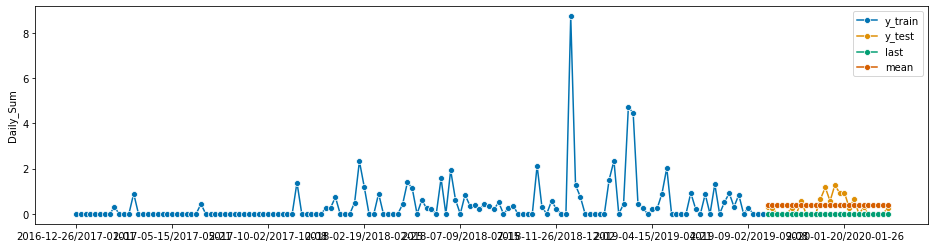

In [74]:
plot_series(y_train, y_test, y_last_preds, y_mean_preds,
            labels=['y_train', 'y_test', 'last', 'mean']);

/Users/melissamcmillan/opt/anaconda3/envs/timer/lib/python3.8/site-packages/pmdarima/utils/visualization.py:219: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  res = tsaplots.plot_acf(


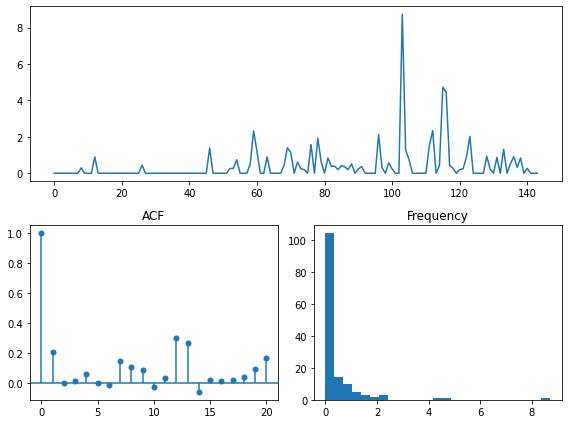

In [75]:
#I'm going to try an auto-arima model
tsdisplay(y_train, lag_max=20)

In [76]:
model = pmd.auto_arima(y_train, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.11 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=476.975, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=459.577, Time=0.46 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=474.975, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=458.112, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=459.618, Time=0.40 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=2.50 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=444.917, Time=0.02 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=446.592, Time=0.56 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=446.616, Time=0.42 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=3.89 sec
 ARIMA(3,1,0)(0,0,0)[52] intercept   : AIC=436.529, Time=0.04 sec
 ARIMA(3,1,0)(1,0,0)[52] intercept   : AIC=438.203, Time=0.71 sec
 ARIMA(3,1,0)(0,0,1)[52] intercept   : AIC=438.22

In [77]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -200.584
Date:                Mon, 01 Mar 2021   AIC                            407.167
Time:                        19:07:00   BIC                            416.056
Sample:                             0   HQIC                           410.779
                                - 144                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7817      0.068    -11.425      0.000      -0.916      -0.648
ma.L2         -0.1686      0.089     -1.893      0.058      -0.343       0.006
sigma2         0.9532      0.027     34.773      0.000       0.899       1.007
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              9307.56
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):              38.24   Skew:                             5.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
arima_preds = model.predict(y_test.shape[0])
arima_preds = pd.Series(arima_preds, y_test.index)
arima_preds

2019-09-30/2019-10-06    0.464907
2019-10-07/2019-10-13    0.547079
2019-10-14/2019-10-20    0.547079
2019-10-21/2019-10-27    0.547079
2019-10-28/2019-11-03    0.547079
2019-11-04/2019-11-10    0.547079
2019-11-11/2019-11-17    0.547079
2019-11-18/2019-11-24    0.547079
2019-11-25/2019-12-01    0.547079
2019-12-02/2019-12-08    0.547079
2019-12-09/2019-12-15    0.547079
2019-12-16/2019-12-22    0.547079
2019-12-23/2019-12-29    0.547079
2019-12-30/2020-01-05    0.547079
2020-01-06/2020-01-12    0.547079
2020-01-13/2020-01-19    0.547079
2020-01-20/2020-01-26    0.547079
2020-01-27/2020-02-02    0.547079
2020-02-03/2020-02-09    0.547079
2020-02-10/2020-02-16    0.547079
2020-02-17/2020-02-23    0.547079
2020-02-24/2020-03-01    0.547079
2020-03-02/2020-03-08    0.547079
2020-03-09/2020-03-15    0.547079
2020-03-16/2020-03-22    0.547079
2020-03-23/2020-03-29    0.547079
Freq: W-SUN, dtype: float64

In [79]:
#get the rmse for the sarimax model
np.round(mse(y_test, arima_preds, squared=False), decimals=2)

0.45

In [80]:
sarimax_rigs = pmd.auto_arima(y_train, X=train_subset[['Rig_Count']], m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.67 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=478.254, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=461.176, Time=0.58 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=2.36 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=476.254, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=459.609, Time=0.04 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=461.211, Time=0.71 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=2.96 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=445.402, Time=0.04 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=447.229, Time=0.82 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=447.242, Time=0.62 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=4.96 sec
 ARIMA(3,1,0)(0,0,0)[52] intercept   : AIC=437.200, Time=0.05 sec
 ARIMA(3,1,0)(1,0,0)[52] intercept   : AIC=439.039, Time=0.99 sec
 ARIMA(3,1,0)(0,0,1)[52] intercept   : AIC=439.05

In [81]:
sarimax_rigs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -200.337
Date:                Mon, 01 Mar 2021   AIC                            408.673
Time:                        19:08:39   BIC                            420.525
Sample:                    01-01-2017   HQIC                           413.489
                         - 09-29-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Rig_Count      0.0255      0.077      0.331      0.740      -0.125       0.176
ma.L1         -0.7810      0.069    -11.279      0.000      -0.917      -0.645
ma.L2         -0.1681      0.090     -1.865      0.062      -0.345       0.009
sigma2         0.9500      0.029     33.109      0.000       0.894       1.006
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              9293.31
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):              35.70   Skew:                             5.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
sarimax_rigs_preds = sarimax_rigs.predict(y_test.shape[0], test_subset[['Rig_Count']])
#get the rmse for the sarimax model
np.round(mse(y_test, sarimax_rigs_preds, squared=False), decimals=2)

0.42

Now to try using WTI Spot Price

In [83]:
X = train_subset[['WTI_Spot_Price']]

In [84]:
sarimax_wti = pmd.auto_arima(y_train, X=X, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.75 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=476.804, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=458.956, Time=0.65 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=412.596, Time=1.51 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=474.805, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=410.700, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=412.582, Time=1.56 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=3.88 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=457.473, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[52]             : AIC=409.277, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[52]             : AIC=411.158, Time=0.74 sec
 ARIMA(0,1,1)(0,0,1)[52]             : AIC=411.169, T

In [85]:
sarimax_wti.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -200.136
Date:                Mon, 01 Mar 2021   AIC                            408.272
Time:                        19:09:19   BIC                            420.124
Sample:                    01-01-2017   HQIC                           413.088
                         - 09-29-2019                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
WTI_Spot_Price    -0.0168      0.019     -0.863      0.388      -0.055       0.021
ma.L1             -0.7807      0.060    -13.082      0.000      -0.898      -0.664
ma.L2             -0.1545      0.088     -1.748      0.080      -0.328       0.019
sigma2             0.9488      0.071     13.336      0.000       0.809       1.088
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              7439.21
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):              35.54   Skew:                             4.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
sarimax_wti_preds = sarimax_wti.predict(y_test.shape[0], test_subset[['WTI_Spot_Price']])
np.round(mse(y_test, sarimax_wti_preds, squared=False), decimals=2)

0.56

Going to test fracs/day as a feature.

In [87]:
X = train_subset[['fracs_per_day']]

In [88]:
sarimax_fracs = pmd.auto_arima(y_train, X=X, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.47 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=475.754, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=458.699, Time=1.00 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=473.756, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=457.009, Time=0.07 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=458.725, Time=0.84 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=2.91 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=443.393, Time=0.06 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=445.224, Time=1.01 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=445.238, Time=0.79 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=3.81 sec
 ARIMA(3,1,0)(0,0,0)[52] intercept   : AIC=435.506, Time=0.07 sec
 ARIMA(3,1,0)(1,0,0)[52] intercept   : AIC=437.282, Time=1.68 sec
 ARIMA(3,1,0)(0,0,1)[52] intercept   : AIC=437.29

In [89]:
sarimax_fracs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -200.331
Date:                Mon, 01 Mar 2021   AIC                            408.662
Time:                        19:11:18   BIC                            420.513
Sample:                    01-01-2017   HQIC                           413.478
                         - 09-29-2019                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
fracs_per_day     0.0061      0.022      0.279      0.781      -0.037       0.049
ma.L1            -0.7773      0.070    -11.185      0.000      -0.914      -0.641
ma.L2            -0.1717      0.095     -1.812      0.070      -0.357       0.014
sigma2            0.9500      0.027     34.585      0.000       0.896       1.004
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              9423.58
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):              35.06   Skew:                             5.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [90]:
sarimax_fracs_preds = sarimax_fracs.predict(y_test.shape[0], test_subset[['fracs_per_day']])
np.round(mse(y_test, sarimax_fracs_preds, squared=False), decimals=2)

0.47

In [91]:
X = train_subset[['volume_per_day']]
sarimax_volume = pmd.auto_arima(y_train, X=X, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=429.440, Time=4.17 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=471.538, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=456.030, Time=2.82 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=434.107, Time=2.54 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1037.233, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=427.440, Time=3.08 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=425.440, Time=0.21 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=428.229, Time=4.04 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=425.092, Time=0.22 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=427.764, Time=3.25 sec
 ARIMA(1,1,2)(0,0,1)[52] intercept   : AIC=427.092, Time=2.82 sec
 ARIMA(1,1,2)(1,0,1)[52] intercept   : AIC=429.092, Time=3.50 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=420.087, Time=0.16 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=422.547, Time=2.77 sec
 ARIMA(0,1,2)(0,0,1)[52] interce

In [92]:
sarimax_volume.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -203.374
Date:                Mon, 01 Mar 2021   AIC                            416.748
Time:                        19:12:47   BIC                            431.563
Sample:                    01-01-2017   HQIC                           422.768
                         - 09-29-2019                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
volume_per_day  1.581e-08   2.81e-08      0.562      0.574   -3.94e-08     7.1e-08
ma.L1             -0.6238      0.060    -10.390      0.000      -0.742      -0.506
ma.L2             -0.2044      0.133     -1.533      0.125      -0.466       0.057
ma.L3             -0.0170      0.099     -0.172      0.863      -0.210       0.176
sigma2             1.1657      0.055     21.287      0.000       1.058       1.273
===================================================================================
Ljung-Box (L1) (Q):                   2.03   Jarque-Bera (JB):              8155.60
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):              31.40   Skew:                             4.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [93]:
sarimax_vol_preds = sarimax_volume.predict(y_test.shape[0], test_subset[['volume_per_day']])
np.round(mse(y_test, sarimax_vol_preds, squared=False), decimals=2)

0.47

In [94]:
X = train_subset[['avg_volh2o_per_ft']]
sarimax_vol_ft = pmd.auto_arima(y_train, X=X, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=417.342, Time=4.86 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=478.944, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=461.527, Time=2.22 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=436.611, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=476.945, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=inf, Time=4.19 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=423.776, Time=4.66 sec
 ARIMA(2,1,2)(2,0,1)[52] intercept   : AIC=inf, Time=24.11 sec
 ARIMA(2,1,2)(1,0,2)[52] intercept   : AIC=inf, Time=21.52 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,1,2)(0,0,2)[52] intercept   : AIC=inf, Time=20.03 sec
 ARIMA(2,1,2)(2,0,0)[52] intercept   : AIC=inf, Time=24.42 sec
 ARIMA(2,1,2)(2,0,2)[52] intercept   : AIC=419.867, Time=26.51 sec
 ARIMA(1,1,2)(1,0,1)[52] intercept   : AIC=427.149, Time=3.04 sec
 ARIMA(2,1,1)(1,0,1)[52] intercept   : AIC=418.610, 

In [95]:
sarimax_vol_ft.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -199.746
Date:                Mon, 01 Mar 2021   AIC                            409.491
Time:                        19:16:35   BIC                            424.305
Sample:                    01-01-2017   HQIC                           415.511
                         - 09-29-2019                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
avg_volh2o_per_ft    -0.0003      0.000     -0.510      0.610      -0.001       0.001
ar.L1                 0.1323      0.086      1.532      0.125      -0.037       0.302
ar.L2                -0.1066      0.133     -0.800      0.424      -0.368       0.155
ma.L1                -0.9407      0.050    -18.808      0.000      -1.039      -0.843
sigma2                0.9383      0.047     19.980      0.000       0.846       1.030
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8606.58
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              37.73   Skew:                             5.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [96]:
sarimax_vol_ft_preds = sarimax_vol_ft.predict(y_test.shape[0], test_subset[['avg_volh2o_per_ft']])
np.round(mse(y_test, sarimax_vol_ft_preds, squared=False), decimals=2)

0.38

Now it's time to model using the Fasola catalog!

In [97]:
fasola = pd.read_csv('oil_and_gas_data/data_for_modelling/fasola_data_ready_for_modelling.csv', index_col=0)
fasola.head()

,Daily_Avg,Daily_Sum,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft,APIs
2016-01-01,0.0,0.0,0,33.0,37.13,36.61,9.0,5.080098e+06,1088.829502,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-02,0.0,0.0,0,33.0,37.13,36.61,11.0,5.892634e+06,1044.749861,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-03,0.0,0.0,0,33.0,37.13,36.61,9.0,4.539134e+06,1125.551135,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-04,0.0,0.0,0,33.0,36.81,36.28,26.0,1.135010e+07,848.112281,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-05,0.0,0.0,0,33.0,35.97,35.56,26.0,1.135010e+07,848.112281,"[42255346090000, 42255346080000, 4225534610000..."


In [98]:
#I think I'm going to use a similar time range as the previous data, so use 1/1/2017-9/30/2019
#to forecast 3Q 2019-1Q2020.
#first I need to resample to weekly
fasola.index = pd.to_datetime(fasola.index)
weekly_fasola = fasola.resample('W').mean()
weekly_fasola.head(3)

,Daily_Avg,Daily_Sum,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2016-01-03,0.000000,0.000000,0.000000,33.0,37.130000,36.610000,9.666667,5.170622e+06,1086.376832
2016-01-10,0.000000,0.000000,0.000000,33.0,34.234286,33.472857,26.571429,1.235401e+07,825.894278
2016-01-17,0.136829,0.136829,0.142857,33.0,30.261429,29.014286,24.285714,1.620145e+07,1014.034459


In [114]:
train_subset =  weekly_fasola.loc['2017':'7-30-2019',]
test_subset = weekly_fasola.loc['8-1-2019':'1-31-2020',]

In [116]:
train_subset

,Daily_Avg,Daily_Sum,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2017-01-01,0.472484,1.427770,1.571429,23.285714,53.412857,54.665714,10.000000,7.635978e+06,1799.664814
2017-01-08,1.046323,8.728730,10.000000,23.142857,53.582857,55.324286,8.714286,7.436396e+06,1696.778656
2017-01-15,0.205967,1.042610,1.142857,21.571429,52.150000,54.117143,9.857143,1.055493e+07,1408.944624
2017-01-22,0.333800,0.419590,0.571429,23.571429,52.044286,54.435714,11.285714,1.102468e+07,1433.821886
2017-01-29,0.188821,0.188821,0.142857,25.000000,52.867143,54.875714,11.142857,1.092944e+07,1651.222458
...,...,...,...,...,...,...,...,...,...
2019-09-01,0.000000,0.000000,0.000000,29.285714,55.167143,60.172857,15.285714,1.328686e+07,2281.137619
2019-09-08,0.271429,0.271429,0.142857,30.000000,55.840000,60.528571,16.285714,1.216854e+07,2229.285065
2019-09-15,0.000000,0.000000,0.000000,30.000000,55.760000,62.312857,15.000000,7.904135e+06,1946.664092
2019-09-22,0.000000,0.000000,0.000000,29.428571,58.928571,65.462857,24.285714,2.016906e+07,2928.348256


In [117]:
test_subset

,Daily_Avg,Daily_Sum,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2019-10-06,0.314286,0.314286,0.142857,25.000000,53.041429,59.195714,27.285714,2.834286e+07,3647.344387
2019-10-13,0.257143,0.257143,0.142857,25.000000,53.697143,59.735714,27.142857,2.793837e+07,3218.020337
2019-10-20,0.000000,0.000000,0.000000,24.714286,53.562857,59.504286,25.857143,2.842720e+07,3142.156819
2019-10-27,0.000000,0.000000,0.000000,24.000000,55.580000,61.122857,27.142857,3.408261e+07,3767.036408
2019-11-03,0.000000,0.000000,0.000000,24.000000,55.418571,60.210000,29.142857,3.378449e+07,3626.834469
2019-11-10,0.271429,0.271429,0.142857,24.000000,56.784286,62.278571,20.000000,2.113730e+07,2679.911109
2019-11-17,0.000000,0.000000,0.000000,24.571429,57.108571,62.780000,12.428571,1.087242e+07,2613.625843
2019-11-24,0.292857,0.585714,0.285714,26.000000,57.122857,64.067143,19.428571,1.598041e+07,2743.437862
2019-12-01,0.000000,0.000000,0.000000,26.000000,58.091429,64.671429,21.428571,1.792321e+07,2723.600440
2019-12-08,0.000000,0.000000,0.000000,26.000000,58.085714,65.224286,22.714286,2.006009e+07,2539.291052


In [118]:
y_train = train_subset[['Daily_Sum']]
y_test = test_subset[['Daily_Sum']]

In [119]:
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

In [120]:
y_train.tail()

,Daily_Sum
2019-09-01,0.000000
2019-09-08,0.271429
2019-09-15,0.000000
2019-09-22,0.000000
2019-09-29,0.000000


Now it's time for baseline models!

In [121]:
#first up will be the Naive Forecast, which is the last value of the train set
y_train.index = y_train.index.to_period('W')
y_test.index = y_test.index.to_period('W')

In [122]:
y_train = y_train['Daily_Sum']
y_test = y_test['Daily_Sum']

In [123]:
#here is the last value/naive model
naive_last = NaiveForecaster(strategy= 'last')
naive_last.fit(y_train)

NaiveForecaster()

In [124]:
y_last_preds = naive_last.predict(list(range(1,len(y_test)+1)))

In [125]:
#get the rmse for the last/naive model
np.round(mse(y_test, y_last_preds, squared=False), decimals=2)

0.6

In [126]:
#here is the simple mean model
naive_mean = NaiveForecaster(strategy= 'mean')
naive_mean.fit(y_train)
y_mean_preds = naive_mean.predict(list(range(1,len(y_test)+1)))

In [127]:
#get the rmse for the mean model
np.round(mse(y_test, y_mean_preds, squared=False), decimals=2)

1.47

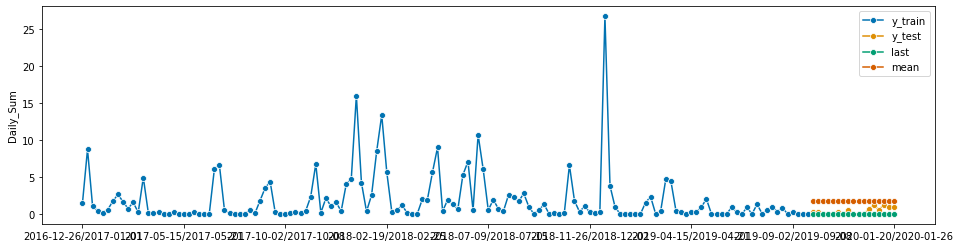

In [128]:
plot_series(y_train, y_test, y_last_preds, y_mean_preds,
            labels=['y_train', 'y_test', 'last', 'mean']);

/Users/melissamcmillan/opt/anaconda3/envs/timer/lib/python3.8/site-packages/pmdarima/utils/visualization.py:219: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  res = tsaplots.plot_acf(


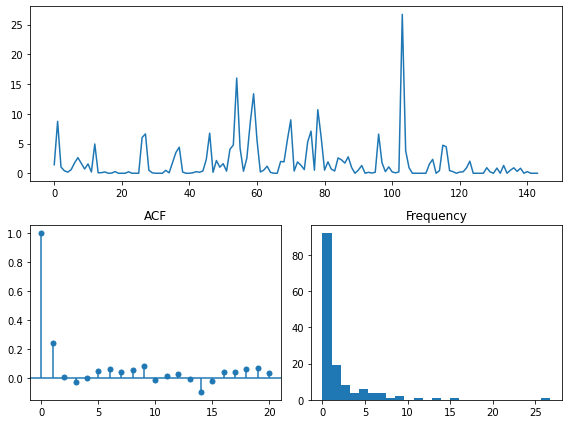

In [129]:
#I'm going to try an auto-arima model
tsdisplay(y_train, lag_max=20)

In [130]:
model = pmd.auto_arima(y_train, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.69 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=763.758, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=758.910, Time=0.73 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=758.502, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=798.048, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=756.865, Time=0.02 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=758.484, Time=0.55 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=2.94 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=758.812, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[52] intercept   : AIC=758.800, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=757.146, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=760.768, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[52]             : AIC=778.545, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[52] intercept
Total fit time: 9.740 seconds


In [131]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -375.432
Date:                Mon, 01 Mar 2021   AIC                            756.865
Time:                        19:26:54   BIC                            765.774
Sample:                             0   HQIC                           760.485
                                - 144                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.8056      0.648      2.787      0.005       0.536       3.076
ma.L1          0.2472      0.082      3.023      0.003       0.087       0.407
sigma2        10.7620      0.649     16.571      0.000       9.489      12.035
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4193.47
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               3.67   Skew:                             4.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [132]:
arima_preds = model.predict(y_test.shape[0])
arima_preds = pd.Series(arima_preds, y_test.index)
arima_preds

2019-09-30/2019-10-06    1.446610
2019-10-07/2019-10-13    1.805639
2019-10-14/2019-10-20    1.805639
2019-10-21/2019-10-27    1.805639
2019-10-28/2019-11-03    1.805639
2019-11-04/2019-11-10    1.805639
2019-11-11/2019-11-17    1.805639
2019-11-18/2019-11-24    1.805639
2019-11-25/2019-12-01    1.805639
2019-12-02/2019-12-08    1.805639
2019-12-09/2019-12-15    1.805639
2019-12-16/2019-12-22    1.805639
2019-12-23/2019-12-29    1.805639
2019-12-30/2020-01-05    1.805639
2020-01-06/2020-01-12    1.805639
2020-01-13/2020-01-19    1.805639
2020-01-20/2020-01-26    1.805639
Freq: W-SUN, dtype: float64

In [133]:
#get the rmse for the sarimax model
np.round(mse(y_test, arima_preds, squared=False), decimals=2)

1.44

Now I'm going to try a sarimax model that takes in exogenous features. The first exogenous feature I want to try is Rig Count. It's a pretty straight-forward feature to understand.

In [134]:
sarimax_rate = pmd.auto_arima(y_train, X=train_subset[['avg_volh2o_per_ft']], m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=771.558, Time=3.74 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=769.850, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=763.656, Time=2.05 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=764.040, Time=1.64 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=768.269, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=761.767, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=763.767, Time=0.96 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=765.767, Time=0.94 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=763.772, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=763.751, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=762.040, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=765.723, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[52]             : AIC=760.022, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52]             : AIC=761.909, Time=1.96 sec
 ARIMA(1,0,0)(0,0,1)[52]         

In [135]:
sarimax_rate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -377.011
Date:                Mon, 01 Mar 2021   AIC                            760.022
Time:                        19:32:25   BIC                            768.932
Sample:                    01-01-2017   HQIC                           763.643
                         - 09-29-2019                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
avg_volh2o_per_ft     0.0007      0.000      2.242      0.025    9.25e-05       0.001
ar.L1                 0.2635      0.080      3.277      0.001       0.106       0.421
sigma2               11.0767      0.621     17.838      0.000       9.860      12.294
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4129.25
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               3.87   Skew:                             4.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
sarimax_rate_preds = sarimax_rate.predict(y_test.shape[0], test_subset[['avg_volh2o_per_ft']])

In [137]:
#get the rmse for the sarimax model
np.round(mse(y_test, sarimax_rate_preds, squared=False), decimals=2)

1.68

Now I'd like to experiment with modelling the data as far back as I can go. I'm going to load in the mega_df dataset and resample to Weekly or Quarterly. I'm also going to use Daily_Avg as my target, because from my EDA plots made in R, that target seemed to be most telling. 

In [163]:
mega_df = pd.read_csv('oil_and_gas_data/data_for_modelling/mega_data_ready_for_modelling.csv', index_col=0)

In [164]:
#first thing to do is drop na values
mega_df = mega_df.dropna()
mega_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2863 entries, 2012-03-02 to 2020-12-05
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Daily_Sum          2863 non-null   float64
 1   Daily_Avg          2863 non-null   float64
 2   Daily_Count        2863 non-null   int64  
 3   Rig_Count          2863 non-null   float64
 4   WTI_Spot_Price     2863 non-null   float64
 5   Brent_Spot_Price   2863 non-null   float64
 6   fracs_per_day      2863 non-null   float64
 7   volume_per_day     2863 non-null   float64
 8   avg_volh2o_per_ft  2863 non-null   float64
 9   APIs               2863 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 246.0+ KB


So the date range I will model is 3-2-2012 to 1-31-2020 (I can do a more recent model, but I'm not ready to model the havoc that COVID caused to the industry). 

In [166]:
mega_df.index = pd.to_datetime(mega_df.index)
mega_df = mega_df.loc[:'1-31-2020',]
mega_df.tail()

,Daily_Sum,Daily_Avg,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft,APIs
2020-01-27,0.0,0.0,0,33.0,53.09,58.54,45.0,4.278683e+07,1642.821249,"[42255361850000, 42255361860000, 4225536568000..."
2020-01-28,1.9,1.9,1,33.0,53.33,59.37,46.0,4.433917e+07,1658.283946,"[42255361850000, 42255361860000, 4225536568000..."
2020-01-29,0.0,0.0,0,33.0,53.29,59.46,44.0,4.293038e+07,1624.508496,"[42255361850000, 42255361860000, 4225536569000..."
2020-01-30,0.0,0.0,0,33.0,52.19,57.72,46.0,4.500210e+07,1624.812672,"[42255361850000, 42255361860000, 4225536559000..."
2020-01-31,0.0,0.0,0,33.0,51.58,57.77,46.0,4.500210e+07,1624.812672,"[42255361850000, 42255361860000, 4225536559000..."


In [167]:
#time to resample to Weekly averages
mega_df_weekly = mega_df.resample('W').mean()

In [168]:
mega_df_weekly.index = mega_df_weekly.index.to_period('W')

In [170]:
mega_df_weekly.dropna(inplace=True)

In [171]:
y = mega_df_weekly['Daily_Avg']
y

2012-02-27/2012-03-04    0.000000
2012-03-05/2012-03-11    0.000000
2012-03-19/2012-03-25    0.000000
2012-03-26/2012-04-01    0.000000
2012-05-28/2012-06-03    0.000000
                           ...   
2019-12-30/2020-01-05    0.571429
2020-01-06/2020-01-12    0.635714
2020-01-13/2020-01-19    0.607143
2020-01-20/2020-01-26    0.928571
2020-01-27/2020-02-02    0.380000
Freq: W-SUN, Name: Daily_Avg, Length: 386, dtype: float64

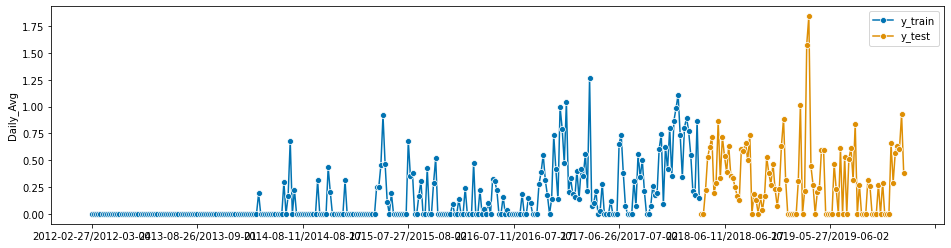

In [173]:
#going to do a train_test_split
y_train, y_test = temporal_train_test_split(y)
plot_series(y_train, y_test, labels=['y_train', 'y_test']);

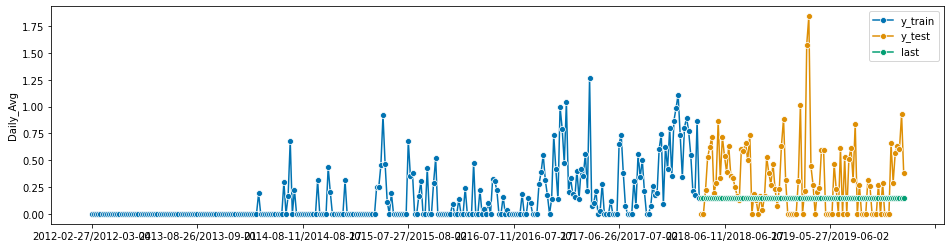

In [174]:
#time to make a baseline null model using the last value
naive_last = NaiveForecaster(strategy= 'last')
naive_last.fit(y_train)
y_last_preds = naive_last.predict(list(range(1,len(y_test)+1)))
plot_series(y_train, y_test, y_last_preds, labels=['y_train', 'y_test', 'last']);

In [177]:
np.round(mse(y_test, y_last_preds, squared=False), decimals=2)

0.38

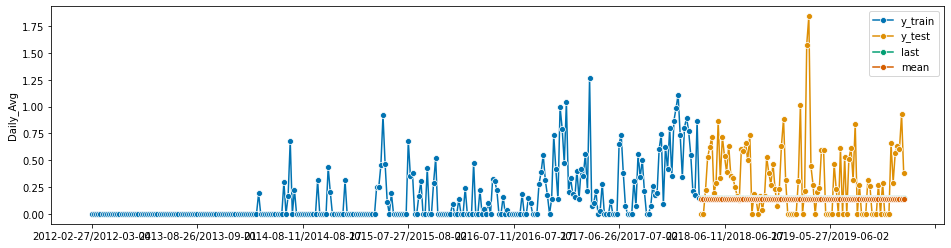

In [178]:
#time to make a baseline null model using the mean value
naive_mean = NaiveForecaster(strategy= 'mean')
naive_mean.fit(y_train)
y_mean_preds = naive_mean.predict(list(range(1,len(y_test)+1)))
plot_series(y_train, y_test, y_last_preds, y_mean_preds, 
            labels=['y_train', 'y_test', 'last', 'mean']);

In [179]:
np.round(mse(y_test, y_mean_preds, squared=False), decimals=2)

0.39

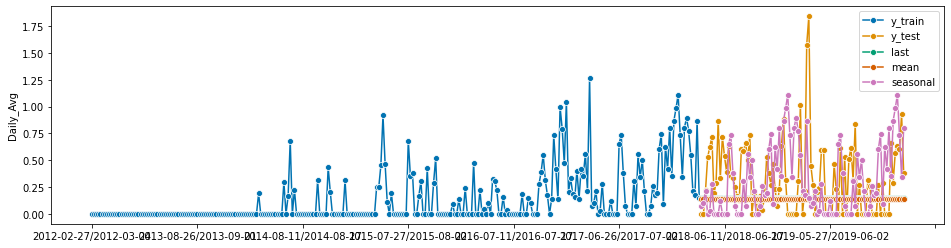

In [180]:
#that did very similar to the last null
#now I'm going to try a seasonal model and see how that does
naive_seasonal = NaiveForecaster(strategy= 'last', sp=52)
naive_seasonal.fit(y_train)

y_seasonal_preds = naive_seasonal.predict(list(range(1,len(y_test)+1)))

plot_series(y_train, y_test, y_last_preds, y_mean_preds, y_seasonal_preds,
            labels=['y_train', 'y_test', 'last', 'mean', 'seasonal']);

In [181]:
np.round(mse(y_test, y_seasonal_preds, squared=False), decimals=2)

0.46

In [182]:
#it didn't do as well as the null, but oh well!
#going to try a SARIMA/Auto-ARIMA model and see how that does
sarima1_mega = AutoARIMA(sp=52, suppress_warnings=True, trace=True)
sarima1_mega.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=6.78 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-16.887, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=-68.766, Time=1.10 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=-109.276, Time=2.21 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=-18.885, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=-110.669, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=-109.140, Time=1.67 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=5.57 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=-116.334, Time=0.13 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=-114.893, Time=3.47 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=-115.040, Time=4.19 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=6.34 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=-70.602, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=-119.215, Time=0.21 sec
 ARIMA(2,1,1)(1,0,0)[52] intercept   :

AutoARIMA(sp=52, suppress_warnings=True, trace=True)

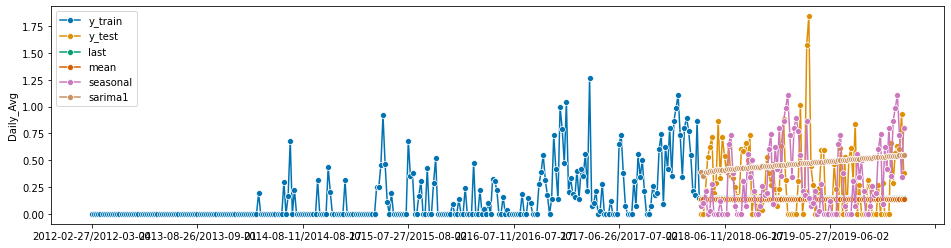

In [183]:
sarima1_preds = sarima1_mega.predict(list(range(1,len(y_test)+1)))
plot_series(y_train, y_test, y_last_preds, y_mean_preds, y_seasonal_preds, sarima1_preds,
            labels=['y_train', 'y_test', 'last', 'mean', 'seasonal', 'sarima1']);

In [184]:
np.round(mse(y_test, sarima1_preds, squared=False), decimals=2)

0.37

In [ ]:
#hey! that one beat the null models! woot!!!

In [185]:
#let's try a holt-winters model and see how that does
#exponential smoothing in the Holt Winters model
hw_model = AutoETS(error='add', trend='add', seasonal='add', suppress_warnings=True, sp=52)
hw_model.fit(y_train)

ValueError: endog must be strictly positive when usingmultiplicative error, trend or seasonal components.

Now I'd like to model using exogenous features, particularly the volume/day, fracs/day and avg vol/ft.

In [187]:
#set up X and y; y will stay the same
X = mega_df_weekly[['fracs_per_day']]

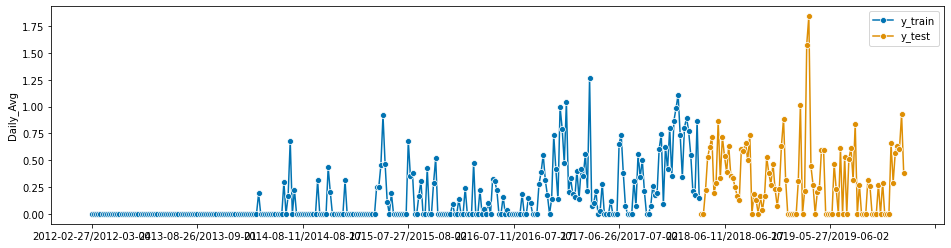

In [188]:
#set up the TTS
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)
plot_series(y_train, y_test, labels=['y_train', 'y_test']);

In [190]:
#double checking the shapes
print(f'X_train shape is {X_train.shape}')
print(f'X_test shape is {X_test.shape}')
print(f'y_train shape is {y_train.shape}')
print(f'y_test shape is {y_test.shape}')

X_train shape is (289, 1)
X_test shape is (97, 1)
y_train shape is (289,)
y_test shape is (97,)


In [191]:
sarima2_fracs = pmd.auto_arima(y_train, X_train, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=-109.756, Time=8.08 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-16.048, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=-69.338, Time=4.47 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=-112.965, Time=4.51 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=-18.047, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=-114.868, Time=0.22 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=-112.944, Time=5.94 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=-110.863, Time=6.25 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=-118.136, Time=0.27 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=-116.347, Time=5.77 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=-116.402, Time=5.91 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=-114.209, Time=7.55 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=-71.306, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=-119.421, Time=0.27 sec
 ARIMA(2,1,1)(1,0,0)[52

In [192]:
sarima2_fracs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  289
Model:               SARIMAX(2, 1, 1)   Log Likelihood                  65.710
Date:                Tue, 02 Mar 2021   AIC                           -119.421
Time:                        16:41:21   BIC                            -97.443
Sample:                    03-04-2012   HQIC                          -110.614
                         - 03-25-2018                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0009      0.001      1.251      0.211      -0.001       0.002
fracs_per_day     0.0011      0.001      2.011      0.044    2.73e-05       0.002
ar.L1             0.3008      0.048      6.263      0.000       0.207       0.395
ar.L2             0.1446      0.048      3.028      0.002       0.051       0.238
ma.L1            -0.9600      0.019    -51.091      0.000      -0.997      -0.923
sigma2            0.0376      0.003     14.851      0.000       0.033       0.043
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):               338.79
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):              11.36   Skew:                             1.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [193]:
sarima2_fracs_preds = sarima2_fracs.predict(y_test.shape[0], X_test)
np.round(mse(y_test, sarima2_fracs_preds, squared=False), decimals=2)

0.4

In [195]:
type(sarima2_fracs_preds)

numpy.ndarray

In [194]:
plot_series(y_train, y_test, sarima2_fracs_preds, labels=['y_train', 'y_test', 'fracs/day']);

TypeError: Data must be a one of (<class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.series.Series'>), but found type: <class 'numpy.ndarray'>

In [196]:
#yup, around the same as the null model; now I'm going to try avg_vol_per_ft
#set up X and y; y will stay the same
X = mega_df_weekly[['avg_volh2o_per_ft']]
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

In [197]:
sarima3_vol = pmd.auto_arima(y_train, X_train, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=-107.728, Time=3.07 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=-43.063, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=-91.322, Time=1.67 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=-83.279, Time=5.48 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=-39.851, Time=0.16 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=-110.730, Time=6.54 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=-112.742, Time=0.26 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=-99.621, Time=6.06 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=-115.138, Time=0.39 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=-110.479, Time=7.13 sec
 ARIMA(1,0,2)(0,0,1)[52] intercept   : AIC=-113.095, Time=10.18 sec
 ARIMA(1,0,2)(1,0,1)[52] intercept   : AIC=-110.217, Time=6.93 sec
 ARIMA(0,0,2)(0,0,0)[52] intercept   : AIC=-94.415, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=-116.301, Time=0.32 sec
 ARIMA(1,0,1)(1,0,0)[52]

In [198]:
sarima3_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  289
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  63.166
Date:                Tue, 02 Mar 2021   AIC                           -118.333
Time:                        16:56:28   BIC                           -103.667
Sample:                    03-04-2012   HQIC                          -112.456
                         - 03-25-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
avg_volh2o_per_ft  9.617e-05   2.35e-05      4.095      0.000    5.01e-05       0.000
ar.L1                 0.8169      0.049     16.568      0.000       0.720       0.913
ma.L1                -0.4781      0.073     -6.590      0.000      -0.620      -0.336
sigma2                0.0386      0.002     17.111      0.000       0.034       0.043
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               360.76
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              11.75   Skew:                             1.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [199]:
sarima3_vol_preds = sarima3_vol.predict(y_test.shape[0], X_test)
np.round(mse(y_test, sarima3_vol_preds, squared=False), decimals=2)

0.36

In [249]:
#hey! this one beat the null model too!
#now to model volume_per_day
X = mega_df_weekly[['volume_per_day']]
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

In [250]:
sarima4_vol_day = pmd.auto_arima(y_train, X_train, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=-100.337, Time=3.47 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-15.250, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=-66.587, Time=2.10 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=-101.683, Time=2.25 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1326.683, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=-104.195, Time=0.11 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=-101.937, Time=2.00 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=-100.163, Time=2.81 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=-105.855, Time=0.12 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=-103.871, Time=2.37 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=-103.277, Time=2.79 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=-101.826, Time=3.35 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=-69.654, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=-102.741, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[5

/Users/melissamcmillan/opt/anaconda3/envs/timer/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/melissamcmillan/opt/anaconda3/envs/timer/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,4)(0,0,0)[52] intercept   : AIC=-107.961, Time=0.17 sec
 ARIMA(1,1,4)(0,0,0)[52] intercept   : AIC=-107.701, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[52]             : AIC=-112.440, Time=0.12 sec
 ARIMA(0,1,3)(1,0,0)[52]             : AIC=-110.413, Time=2.41 sec
 ARIMA(0,1,3)(0,0,1)[52]             : AIC=-109.870, Time=2.43 sec
 ARIMA(0,1,3)(1,0,1)[52]             : AIC=-108.369, Time=3.00 sec
 ARIMA(0,1,2)(0,0,0)[52]             : AIC=-110.684, Time=0.10 sec


/Users/melissamcmillan/opt/anaconda3/envs/timer/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/melissamcmillan/opt/anaconda3/envs/timer/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,3)(0,0,0)[52]             : AIC=6.105, Time=0.12 sec
 ARIMA(0,1,4)(0,0,0)[52]             : AIC=-113.422, Time=0.16 sec
 ARIMA(0,1,4)(1,0,0)[52]             : AIC=-111.043, Time=2.63 sec
 ARIMA(0,1,4)(0,0,1)[52]             : AIC=-110.958, Time=2.97 sec
 ARIMA(0,1,4)(1,0,1)[52]             : AIC=-109.374, Time=3.70 sec
 ARIMA(1,1,4)(0,0,0)[52]             : AIC=-109.978, Time=0.18 sec
 ARIMA(0,1,5)(0,0,0)[52]             : AIC=-112.773, Time=0.19 sec
 ARIMA(1,1,5)(0,0,0)[52]             : AIC=-109.511, Time=0.19 sec

Best model:  ARIMA(0,1,4)(0,0,0)[52]          
Total fit time: 58.989 seconds


In [202]:
sarima4_vol_day.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  289
Model:               SARIMAX(0, 1, 4)   Log Likelihood                  62.711
Date:                Tue, 02 Mar 2021   AIC                           -113.422
Time:                        17:01:02   BIC                            -91.444
Sample:                    03-04-2012   HQIC                          -104.615
                         - 03-25-2018                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
volume_per_day  5.193e-10   6.51e-10      0.798      0.425   -7.57e-10     1.8e-09
ma.L1             -0.6542      0.009    -74.400      0.000      -0.671      -0.637
ma.L2             -0.0736      0.009     -7.847      0.000      -0.092      -0.055
ma.L3             -0.0270      0.010     -2.710      0.007      -0.047      -0.007
ma.L4             -0.0438      0.007     -5.897      0.000      -0.058      -0.029
sigma2             0.0406      0.002     19.052      0.000       0.036       0.045
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               244.37
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):              12.56   Skew:                             1.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.08e+17. Standard errors may be unstable.
"""

In [203]:
sarima4_vol_preds = sarima4_vol_day.predict(y_test.shape[0], X_test)
np.round(mse(y_test, sarima4_vol_preds, squared=False), decimals=2)

0.38

In [ ]:
#about the same as the null model

In [ ]:
#I'm going to try an sktime version of this sarima model as I've been using pmdarima


In [251]:
sktime_sarima = AutoARIMA(sp=52, suppress_warnings=True, trace=True)

In [253]:
sktime_sarima.fit(y_train, X_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=-100.337, Time=3.03 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-15.250, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=-66.587, Time=2.13 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=-101.683, Time=2.03 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1326.683, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=-104.195, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=-101.937, Time=1.90 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=-100.163, Time=2.59 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=-105.855, Time=0.13 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=-103.871, Time=2.14 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=-103.277, Time=2.26 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=-101.826, Time=2.73 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=-69.654, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=-102.741, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[5

/Users/melissamcmillan/opt/anaconda3/envs/timer/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/melissamcmillan/opt/anaconda3/envs/timer/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,4)(0,0,0)[52] intercept   : AIC=-107.961, Time=0.17 sec
 ARIMA(1,1,4)(0,0,0)[52] intercept   : AIC=-107.701, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[52]             : AIC=-112.440, Time=0.11 sec
 ARIMA(0,1,3)(1,0,0)[52]             : AIC=-110.413, Time=2.21 sec
 ARIMA(0,1,3)(0,0,1)[52]             : AIC=-109.870, Time=2.40 sec
 ARIMA(0,1,3)(1,0,1)[52]             : AIC=-108.369, Time=2.96 sec
 ARIMA(0,1,2)(0,0,0)[52]             : AIC=-110.684, Time=0.10 sec


/Users/melissamcmillan/opt/anaconda3/envs/timer/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/melissamcmillan/opt/anaconda3/envs/timer/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,3)(0,0,0)[52]             : AIC=6.105, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[52]             : AIC=-113.422, Time=0.14 sec
 ARIMA(0,1,4)(1,0,0)[52]             : AIC=-111.043, Time=2.47 sec
 ARIMA(0,1,4)(0,0,1)[52]             : AIC=-110.958, Time=2.77 sec
 ARIMA(0,1,4)(1,0,1)[52]             : AIC=-109.374, Time=3.27 sec
 ARIMA(1,1,4)(0,0,0)[52]             : AIC=-109.978, Time=0.15 sec
 ARIMA(0,1,5)(0,0,0)[52]             : AIC=-112.773, Time=0.17 sec
 ARIMA(1,1,5)(0,0,0)[52]             : AIC=-109.511, Time=0.18 sec

Best model:  ARIMA(0,1,4)(0,0,0)[52]          
Total fit time: 52.739 seconds


AutoARIMA(sp=52, suppress_warnings=True, trace=True)

In [254]:
sktime_sarima_preds = sktime_sarima.predict(list(range(1,len(y_test)+1)))

ValueError: When an ARIMA is fit with an X array, it must also be provided one for predicting or updating observations.

Now I'd like to try an esemble model of the autoarima I did and the avg_volh2o_per_ft model since those two did the best.

In [204]:
#going to set up my X again and do TTS
X = mega_df_weekly[['avg_volh2o_per_ft']]
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

In [207]:
forecaster = EnsembleForecaster([
    ('sarima1_mega', sarima1_mega),
    ('sarima3_vol', sarima3_vol)])

In [208]:
forecaster.fit(y_train, X_train)

ValueError: The estimator ARIMA should be a Forecaster.